# Imports

In [1]:
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import sklearn.decomposition as skdec

In [2]:
from Functions import get_ages_cols, get_param_names, get_category_cols, name_from_index, bool_from_index

## Directories etc.

In [3]:
data_save_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta/all_data"
plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

# Get data

In [4]:
all_data = pd.read_csv(os.path.join(data_save_path, 'all_data.csv'), index_col=0)
all_data_z = pd.read_csv(os.path.join(data_save_path, 'all_data_z.csv'), index_col=0)
all_data_long = pd.read_csv(os.path.join(data_save_path, 'all_data_long.csv'), index_col=0)
all_data_long_z = pd.read_csv(os.path.join(data_save_path, 'all_data_long_z.csv'), index_col=0)

In [5]:
ages_dir = "C:/Users/maria/MEGAsync/SLCNdata/SLCNinfo2.csv"
ages = pd.read_csv(os.path.join(ages_dir))

In [6]:
ages_cols = get_ages_cols()
param_names = get_param_names()
category_cols = get_category_cols()

# Dimensionality reduction (PCA)

In [7]:
# Run PCA
def run_pca(pca_dat):
    
    pca = skdec.PCA(n_components=pca_dat.shape[1])
    # pca = KernelPCA(n_components=z_dat.shape[1])
    fit = pca.fit_transform(pca_dat)
    
    return pca, fit

# Run PCA on all data
ids_all = all_data_z.drop(columns=ages_cols[1:] + ['age_group']).dropna().ID
pca_dat_all = all_data_z.drop(columns=ages_cols + ['age_group']).dropna()
pca_all, fit_all = run_pca(pca_dat_all)

# Run PCA on behavior only
param_cols = []
for col in all_data_z.columns:
    for param_name in param_names:
        if param_name in col:
            param_cols += [col]

ids_beh = all_data_z.drop(columns=ages_cols[1:] + ['age_group'] + param_cols).dropna().ID
pca_dat_beh = all_data_z.drop(columns=ages_cols + ['age_group'] + param_cols).dropna()
pca_beh, fit_beh = run_pca(pca_dat_beh)

# Run PCA on params only
ids_par = all_data_z[param_cols + ['ID']].dropna().ID
pca_dat_par = all_data_z[param_cols].dropna()
pca_par, fit_par = run_pca(pca_dat_par)

Explained variance at 20 components: 84.6%.


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCAExplainedVarianceAll.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


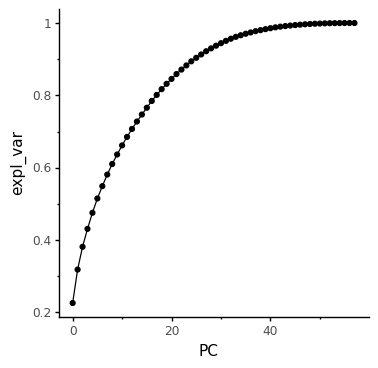

<ggplot: (-9223371941068859353)>
Explained variance at 20 components: 90.8%.


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCAExplainedVarianceBeh.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


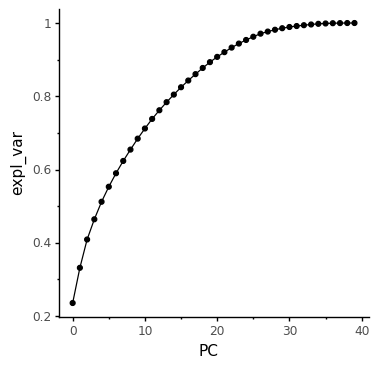

<ggplot: (95787269668)>
Explained variance at 20 components: 100.0%.


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCAExplainedVariancePar.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


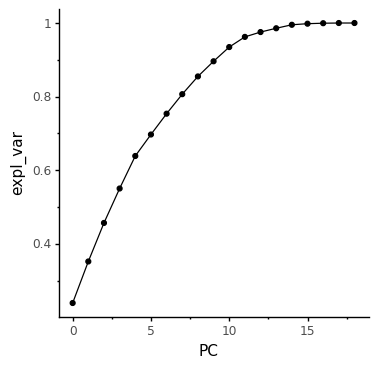

<ggplot: (-9223371941066438140)>


In [8]:
# Plot explained variance
def plot_expl_var(pca_dat, pca, name):
    
    n_comp = 20
    expl_var_dat = pd.DataFrame({'PC': range(pca_dat.shape[1]), 'expl_var': np.cumsum(pca.explained_variance_ratio_)})
    expl_var_at_n_comp = list(expl_var_dat[expl_var_dat.PC <= n_comp].expl_var)[-1]
    print("Explained variance at {} components: {}%.".format(n_comp, round(100 * expl_var_at_n_comp, 1)))

    g = (gg.ggplot(expl_var_dat, gg.aes('PC', 'expl_var'))
         + gg.geom_point()
         + gg.geom_line()
    #      + gg.geom_hline(yintercept=1, linetype='dashed')
    #      + gg.geom_hline(yintercept=expl_var_at_n_comp, linetype='dotted')
    #      + gg.geom_vline(xintercept=n_comp, linetype='dotted')
    )
    g.save(os.path.join(plot_save_path, '3_PCAExplainedVariance{}.png'.format(name)))
    print(g)
    
# Explained variance all behaviors
gg.options.figure_size = (4, 4)
plot_expl_var(pca_dat_all, pca_all, 'All')
plot_expl_var(pca_dat_beh, pca_beh, 'Beh')
plot_expl_var(pca_dat_par, pca_par, 'Par')

In [9]:
def create_fit_pd(fit, pca_dat, ids, ages_sub, n_comp=9):
    
    # fit_pd
    fit_pd = pd.DataFrame(fit,
                          columns=['pc{}'.format(i) for i in range(pca_dat.shape[1])],
                          index=ids)
    fit_pd = fit_pd.reset_index()
    fit_pd = fit_pd.merge(ages_sub)
    
    # fit_long
    fit_pd_long = fit_pd.melt(
        value_vars=['pc{}'.format(i) for i in range(n_comp)],
        id_vars=ages_cols)

    return fit_pd, fit_pd_long

# Create fit_pd's
ages_sub = ages[ages_cols]
fit_pd_all, fit_pd_long_all = create_fit_pd(fit_all, pca_dat_all, ids_all, ages_sub)
fit_pd_beh, fit_pd_long_beh = create_fit_pd(fit_beh, pca_dat_beh, ids_beh, ages_sub)
fit_pd_par, fit_pd_long_par = create_fit_pd(fit_par, pca_dat_par, ids_par, ages_sub)

# Save as csv
fit_pd_all.to_csv(os.path.join(data_save_path, 'fit_pd_all.csv'))
fit_pd_beh.to_csv(os.path.join(data_save_path, 'fit_pd_beh.csv'))
fit_pd_par.to_csv(os.path.join(data_save_path, 'fit_pd_par.csv'))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc0Pc1_Age_All.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc2Pc3_Age_All.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs

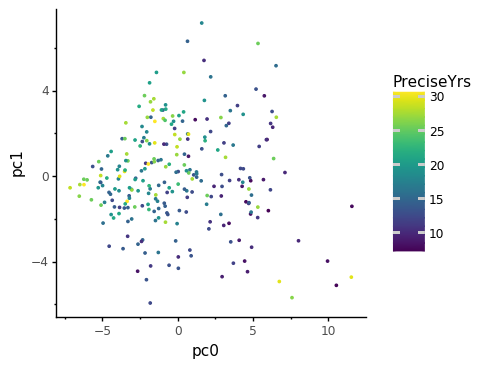

<ggplot: (139955236928)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc0Pc1_Age_Beh.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc2Pc3_Age_Beh.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs

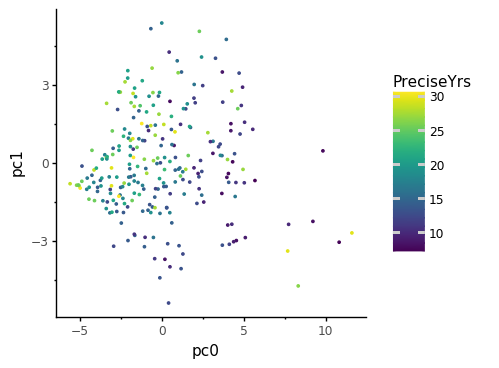

<ggplot: (139955244145)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc0Pc1_Age_Par.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc2Pc3_Age_Par.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs

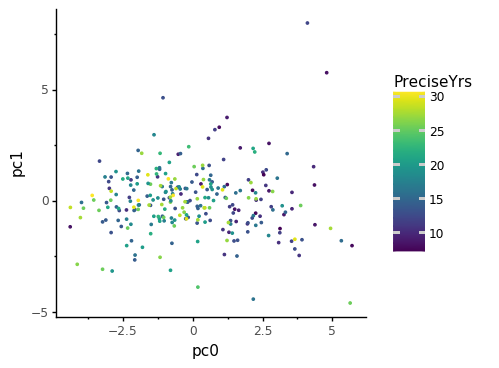

<ggplot: (-9223371896899485387)>


In [10]:
# Age in PC space
def plot_age_in_pc_space(fit_pd, name):
    
    g1 = (gg.ggplot(fit_pd, gg.aes('pc0', 'pc1', color='PreciseYrs'))
     + gg.geom_point(size=0.5)
    )
    g1.save(os.path.join(plot_save_path, '3_Pc0Pc1_Age_{}.png'.format(name)))

    g2 = g1 + gg.aes('pc2', 'pc3')
    g2.save(os.path.join(plot_save_path, '3_Pc2Pc3_Age_{}.png'.format(name)))
    
    g3 = g1 + gg.aes(color='PDS')
    g3.save(os.path.join(plot_save_path, '3_Pc0Pc1_PDS_{}.png'.format(name)))

    g4 = g1 + gg.aes(color='meanT')
    g4.save(os.path.join(plot_save_path, '3_Pc0Pc1_T_{}.png'.format(name)))
    
    print(g1)

# Run on all measures
plot_age_in_pc_space(fit_pd_all, 'All')
plot_age_in_pc_space(fit_pd_beh, 'Beh')
plot_age_in_pc_space(fit_pd_par, 'Par')

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsOverAgeAll.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


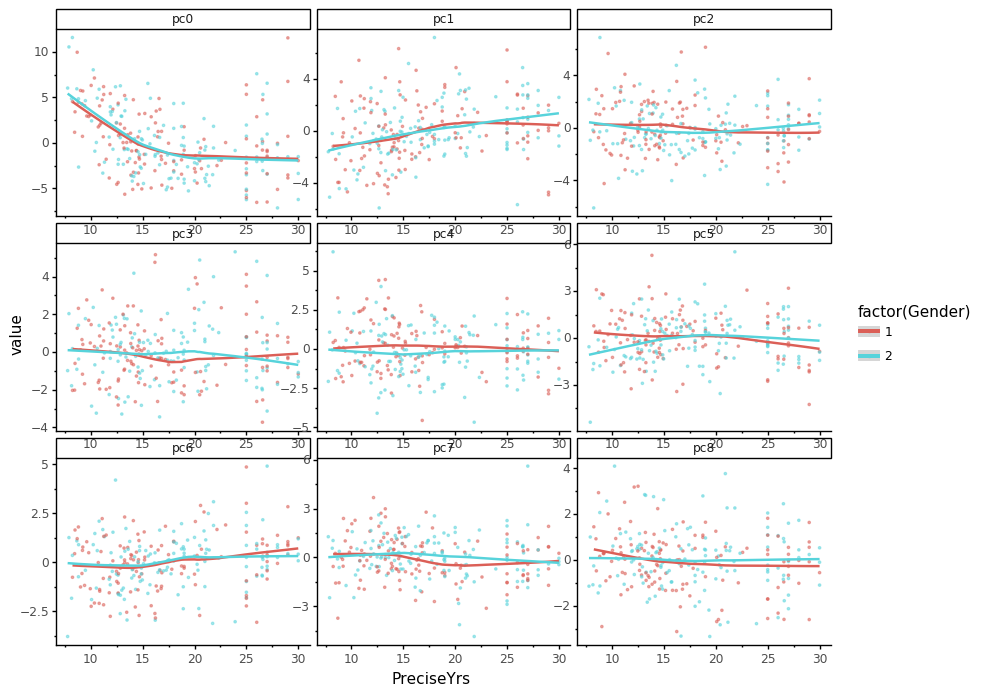

<ggplot: (139956591992)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsOverTAll.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 531 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\An

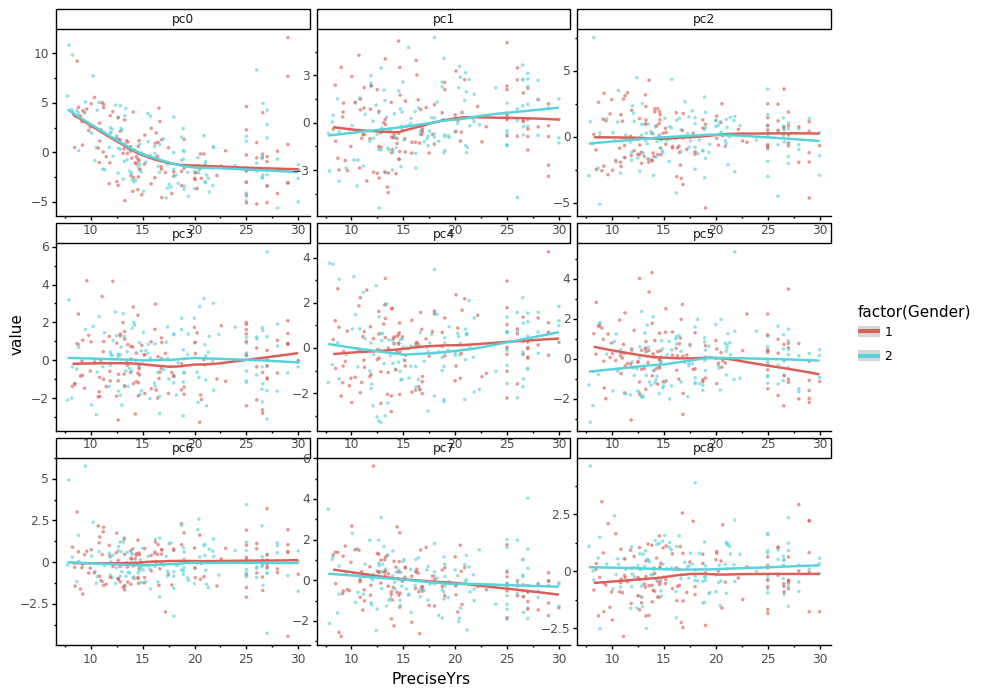

<ggplot: (-9223371896897016225)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsOverTBeh.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 531 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\An

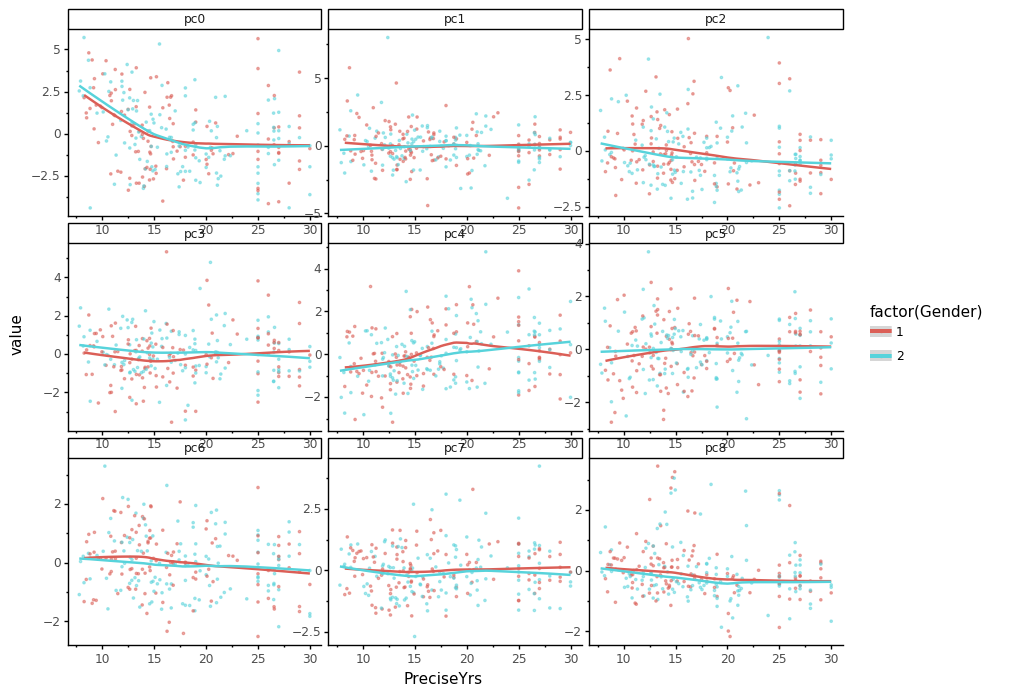

<ggplot: (139954018077)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsOverTPar.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 531 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\An

In [11]:
# PC changes over age
def plot_pcs_over_age(fit_pd_long, name):
    
    gg.options.figure_size = (10, 8)
    g = (gg.ggplot(fit_pd_long, gg.aes('PreciseYrs', 'value', color='factor(Gender)'))
     + gg.geom_point(alpha=0.5, size=0.5)
     + gg.geom_smooth()
     + gg.facet_wrap('~ variable', scales='free')
    )
    g.save(os.path.join(plot_save_path, '3_PcsOverAge{}.png'.format(name)))
    print(g)
    
    g_t = g + gg.aes(x='meanT')
    g_t.save(os.path.join(plot_save_path, '3_PcsOverT{}.png'.format(name)))
    
    g_pds = g + gg.aes(x='PDS')
    g_pds.save(os.path.join(plot_save_path, '3_PcsOverPDS{}.png'.format(name)))
    
# Plot all
plot_pcs_over_age(fit_pd_long_all, 'All')
plot_pcs_over_age(fit_pd_long_beh, 'Beh')
plot_pcs_over_age(fit_pd_long_par, 'Par')

In [10]:
# Factor loadings
choice_param_cols = []
update_param_cols = []
for col in all_data.columns:
    if ('beta' in col) or ('epsilon' in col) or ('forget' in col):
        choice_param_cols += [col]
    if 'alpha' in col:
        update_param_cols += [col]

In [30]:
def create_loadings_long(pca, pca_dat, n_comp=10):
    
    loadings = pca.components_[:n_comp].T  # (n_components, n_features)
    loadings_pd = pd.DataFrame(loadings, columns=['pc{}'.format(i) for i in range(n_comp)], index=pca_dat.columns)
    loadings_pd = loadings_pd.reset_index()
    loadings_long = loadings_pd.melt(
        value_vars=['pc{}'.format(i) for i in range(n_comp)],
        id_vars=['index'])
    
    loadings_long['task'] = loadings_long['index'].apply(lambda x : x[:2])
    loadings_long['ACC_RT'] = loadings_long['index'].apply(name_from_index, names=['ACC', 'RT'])
    loadings_long['category'] = loadings_long['index'].apply(name_from_index, names=category_cols)
    loadings_long['param_bool'] = loadings_long['index'].apply(bool_from_index, names=param_cols)
    loadings_long['PC'] = loadings_long['variable'].apply(lambda x : int(x[2:]))
    loadings_long['pc<0>'] = loadings_long['value'].apply(lambda x: 'pc>0' if x > 0 else 'pc<0')

    for param in choice_param_cols:
        loadings_long.loc[loadings_long['index'] == param, 'category'] = 'choice_param'
    for param in update_param_cols:
        loadings_long.loc[loadings_long['index'] == param, 'category'] = 'update_param'
    
    return loadings_long

# All
loadings_long_all = create_loadings_long(pca_all, pca_dat_all)
loadings_long_beh = create_loadings_long(pca_beh, pca_dat_beh)
loadings_long_par = create_loadings_long(pca_par, pca_dat_par)

In [31]:
# Save as csv
loadings_long_all.to_csv(os.path.join(data_save_path, 'loadings_long_all.csv'))
loadings_long_beh.to_csv(os.path.join(data_save_path, 'loadings_long_beh.csv'))
loadings_long_par.to_csv(os.path.join(data_save_path, 'loadings_long_par.csv'))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCALoadings_All_beh_only.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


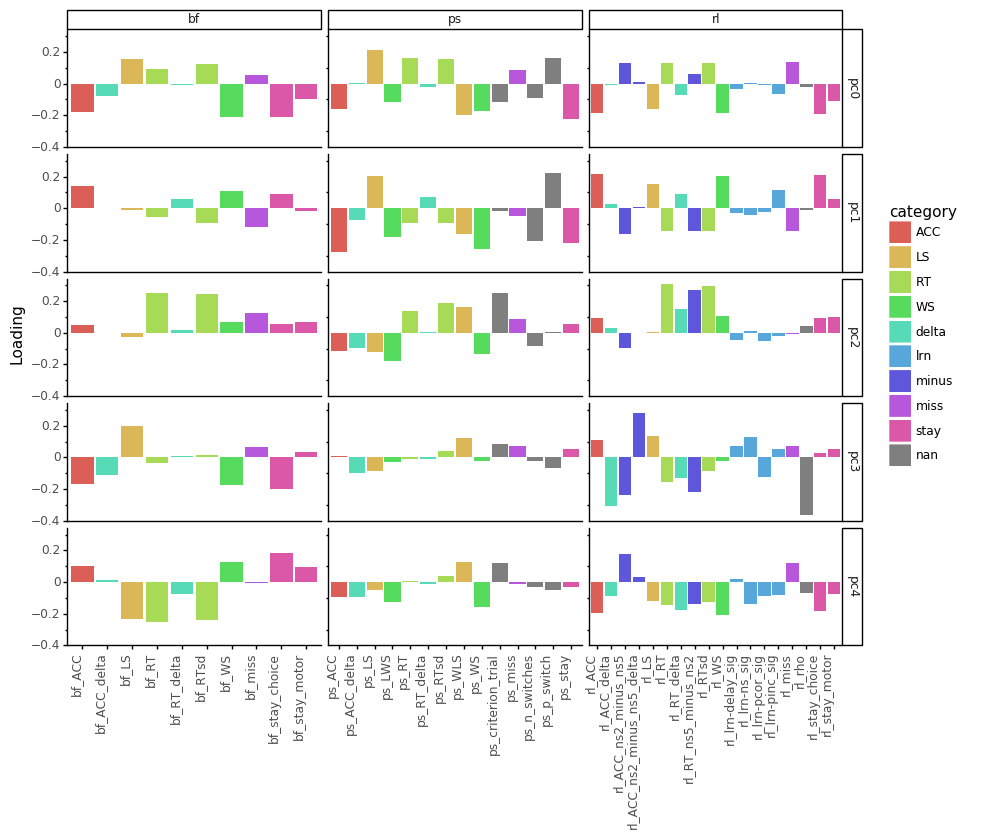

<ggplot: (-9223371896899398505)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCALoadings_All_par_only.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


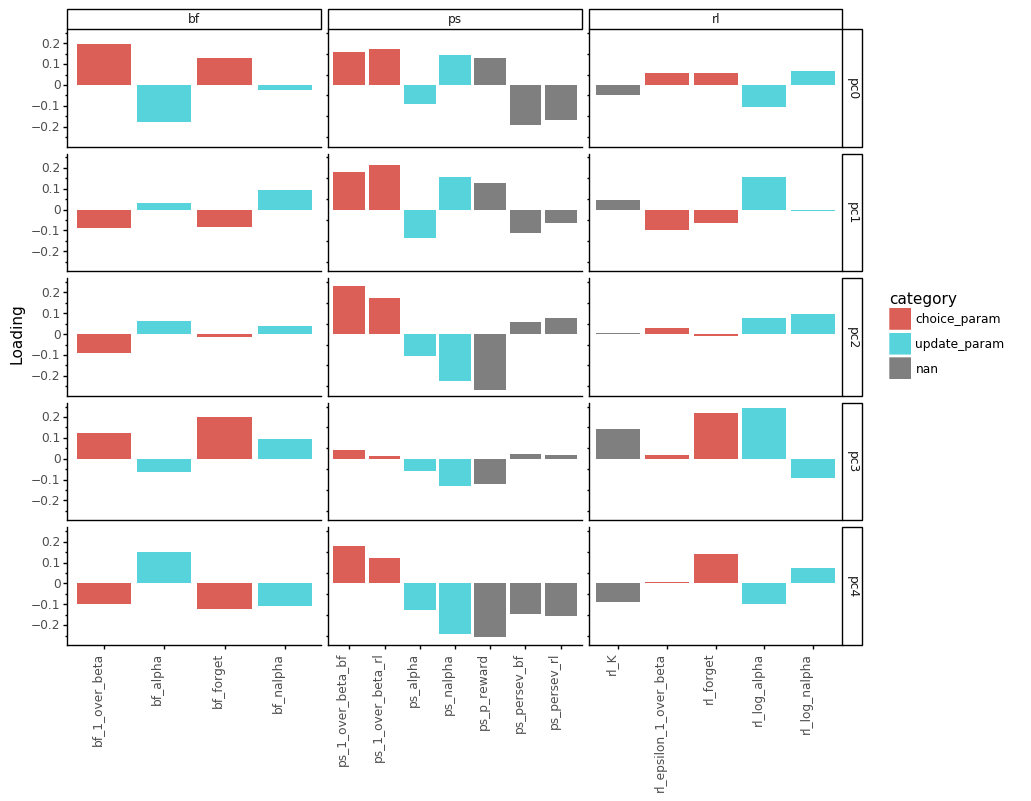

<ggplot: (-9223371896899357422)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCALoadings_All.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


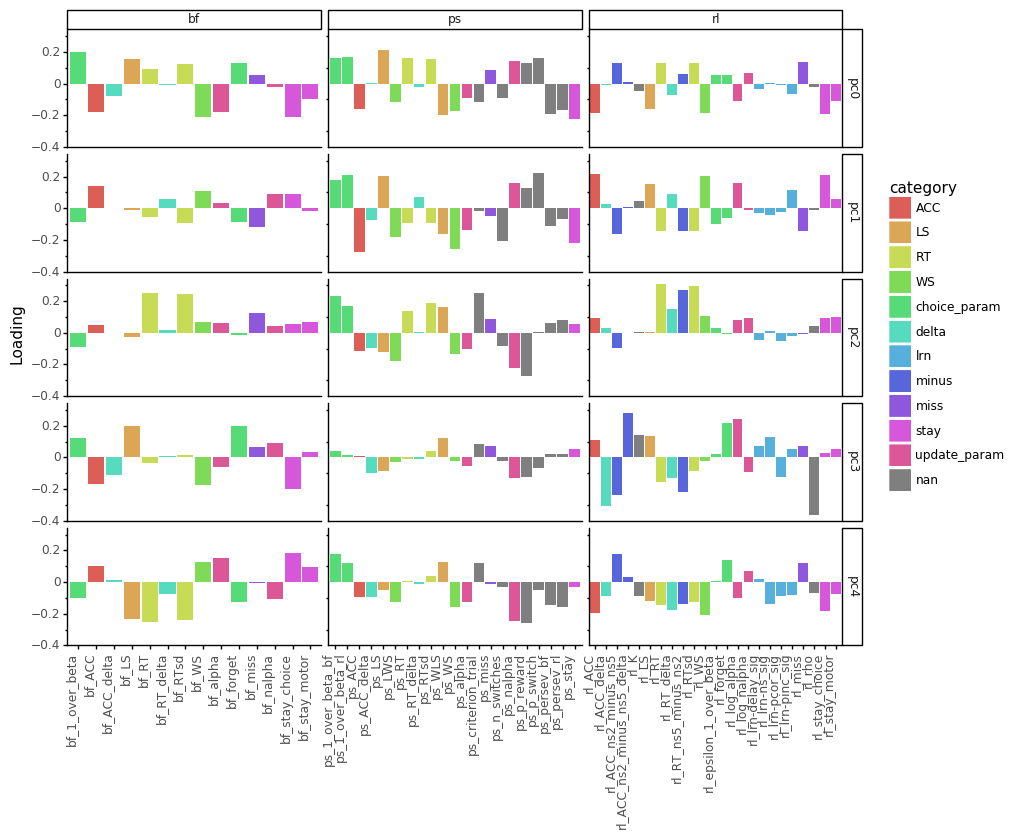

<ggplot: (-9223371896898204528)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCALoadings_Beh.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


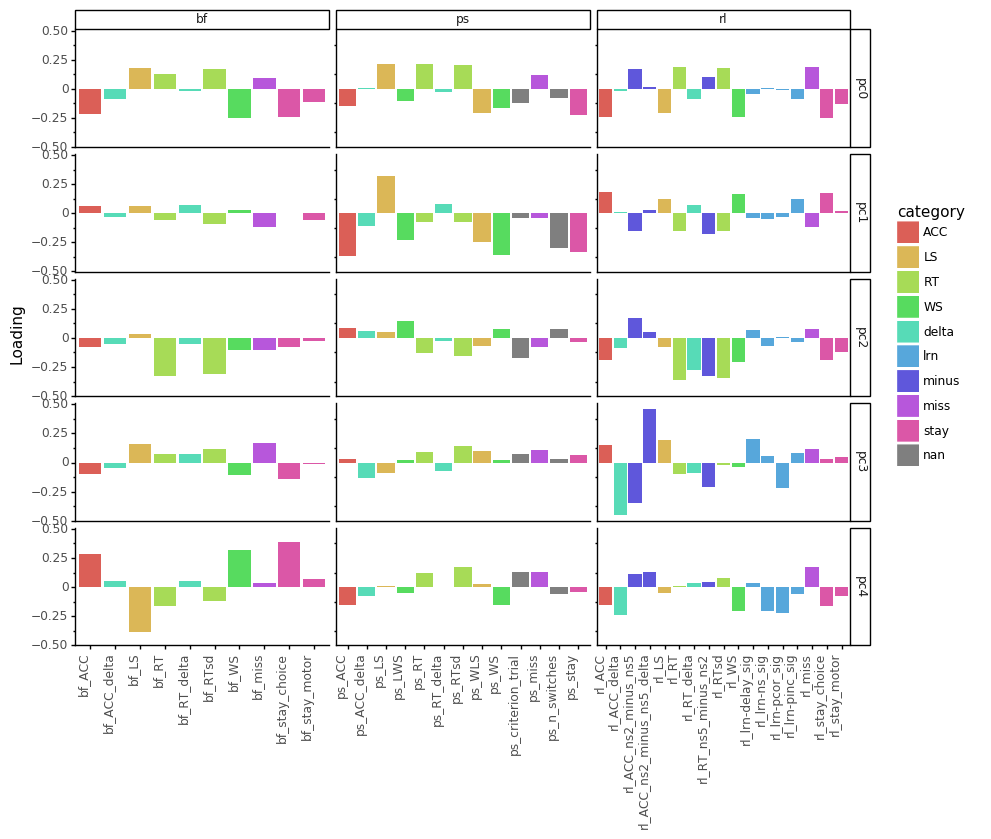

<ggplot: (139955210749)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCALoadings_Par.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


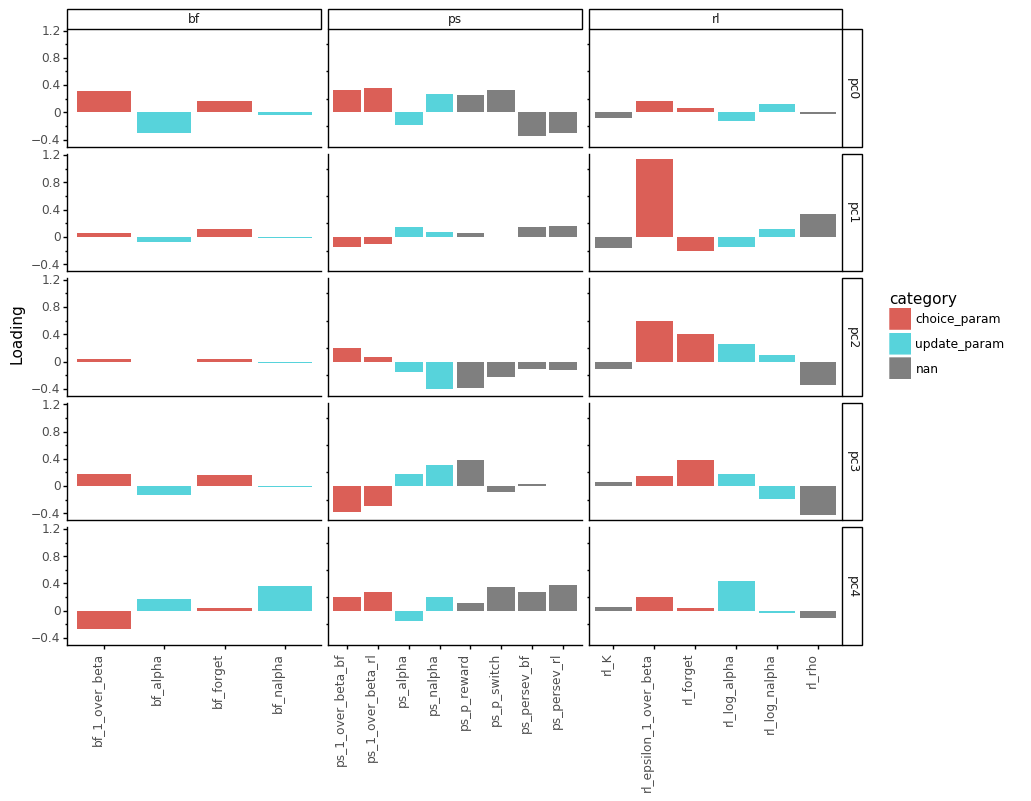

<ggplot: (139956972310)>


In [14]:
def plot_loadings(loadings_long, name, n_comp=5):

    if 'beh_only' in name:
        sub_dat = loadings_long[(loadings_long['PC'] < n_comp) & np.invert(loadings_long['param_bool'])]
    elif 'par_only' in name:
        sub_dat = loadings_long[(loadings_long['PC'] < n_comp) & (loadings_long['param_bool'])]
    else:
        sub_dat = loadings_long[loadings_long['PC'] < n_comp]

    gg.options.figure_size = (10, 8)
    g = (gg.ggplot(sub_dat, gg.aes('index', 'value', fill='category'))
         + gg.geom_bar(stat='identity')
         + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=1))
         + gg.facet_grid('variable ~ task', scales='free_x')
         + gg.labs(x='', y='Loading')
    )
    g.save(os.path.join(plot_save_path, '3_PCALoadings_{}.png'.format(name)))
    print(g)
    
# Plot
plot_loadings(loadings_long_all, 'All_beh_only')
plot_loadings(loadings_long_all, 'All_par_only')
plot_loadings(loadings_long_all, 'All')
plot_loadings(loadings_long_beh, 'Beh')
plot_loadings(loadings_long_par, 'Par')

In [15]:
# Plot behavioral and parameter PCs against each other
fit_pd_behpar = pd.merge(fit_pd_long_beh, fit_pd_long_par, on=ages_cols + ["ID"], suffixes=("_beh", "_par"))
fit_pd_behpar

,ID,PreciseYrs,BMI,Gender,meanT,PDS,variable_beh,value_beh,variable_par,value_par
0,17,8.657084,18.200751,2.0,NaN,2.5,pc0,4.210539,pc0,4.360485
1,17,8.657084,18.200751,2.0,NaN,2.5,pc0,4.210539,pc1,0.717263
2,17,8.657084,18.200751,2.0,NaN,2.5,pc0,4.210539,pc2,-0.165728
3,17,8.657084,18.200751,2.0,NaN,2.5,pc0,4.210539,pc3,-0.411513
4,17,8.657084,18.200751,2.0,NaN,2.5,pc0,4.210539,pc4,0.529794
...,...,...,...,...,...,...,...,...,...,...
20731,469,19.000000,NaN,2.0,NaN,NaN,pc8,-0.232280,pc4,0.306343
20732,469,19.000000,NaN,2.0,NaN,NaN,pc8,-0.232280,pc5,-2.183093
20733,469,19.000000,NaN,2.0,NaN,NaN,pc8,-0.232280,pc6,1.947681
20734,469,19.000000,NaN,2.0,NaN,NaN,pc8,-0.232280,pc7,-0.599242


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


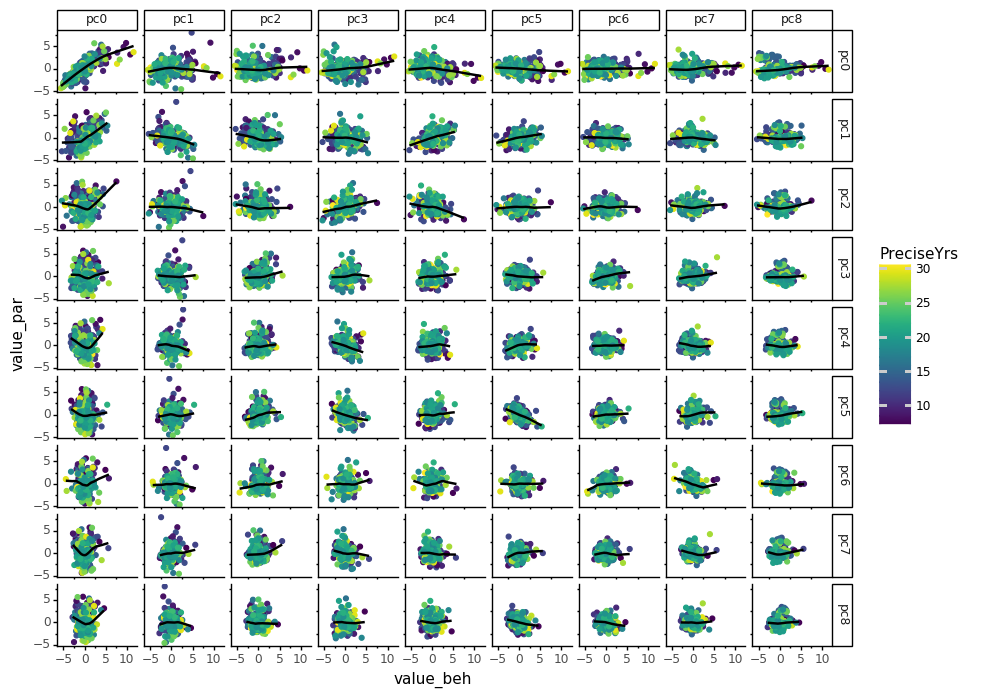

<ggplot: (139956587156)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsBehVersusPcsPar.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


In [16]:
gg.options.figsize = (20, 20)
g = (gg.ggplot(fit_pd_behpar, gg.aes("value_beh", "value_par", color='PreciseYrs'))
     + gg.geom_point()
     + gg.geom_smooth()
     + gg.facet_grid("variable_beh ~ variable_par")
    )
print(g)
g.save(os.path.join(plot_save_path, '3_PcsBehVersusPcsPar.png'))